# Visualisations avancées

In [1]:
#Import library
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from dateutil.parser import parse
from scipy.interpolate import griddata
import plotly
import dash
import plotly.express as px  # (version 4.7.0 or higher)
import plotly.graph_objects as go
import dash_core_components as dcc
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import io
import base64
from PIL import Image
import pandas as pd

/Users/ceciliaacosta/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  if sys.path[0] == '':
/Users/ceciliaacosta/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  


### Partie 1: Transformation des donnée


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Liste des années pour lesquelles vous avez des fichiers CSV
annees = [2021]

# Créez une liste pour stocker les DataFrames de chaque année
dataframes_par_annee = []

for annee in annees:
    # Chargez le fichier CSV de chaque année
    file_path = f"/Users/ceciliaacosta/IFT-DATASCIENCE/MILESTONE1_local/cleaned_data/{annee}.csv"  # Remplacez par le chemin réel
    df_annee = pd.read_csv(file_path)
    dataframes_par_annee.append(df_annee)

# Concaténez les DataFrames en un seul
nhl_data = pd.concat(dataframes_par_annee, ignore_index=True)
nhl_data_tr=nhl_data.copy()
nhl_data_tr['about.dateTime'] = nhl_data_tr['about.dateTime'].apply(lambda x: parse(x).year)

- On extrait l'année du champ "date"
- On modifie l'image pour avoir uniquement la zone offensive


In [6]:
# Open the image
image = Image.open('nhl_rink.png')
# Get the dimensions of the original image
width, height = image.size
# Calculate the coordinates for cropping
left = 0
top = 0
right = width / 2
bottom = height
# Crop the left half
left_half = image.crop((left, top, right, bottom))
left_half.save('left_half.png')

- On prend la valeur absolue des x et on inverse les valeurs de y associées aux x negatifs pour garder la même trajectoire
 -  On garde uniquement les valeurs qui sont dans le rectangle de la trajectoire donc devant le but uniquement (on enlève les valeurs qui sont derrière le but).

In [29]:
df = nhl_data_tr.copy() 
condition = df['coordinates.x'] < 0 
df.loc[condition, ['coordinates.x', 'coordinates.y']] *= -1 #on prend la valeur absolue des x et on inverse les valeurs de y associées aux x negatifs pour garder la même trajectoire
df['coordinates.x'] = abs(df['coordinates.x'] - 89)

### Étape 2 : calculer les statistiques agrégées des emplacements des tirs pour calculer le taux de tir moyen de la ligue par heure

In [8]:
def shotrate_per_location(df):
    """
    Calculate the shot rate per location in the rink 
    """
    # Total games
    total_games = df['ID_game'].nunique()

    # Total shots per location 
    ser_total_shots= df.groupby(['coordinates.x', 'coordinates.y']).count()
    df_total_shots=pd.DataFrame(ser_total_shots['ID_game'])
    df_total_shots=df_total_shots.rename(columns={'ID_game':'coord_total_shots'})

    # Calculate the rate per hour of the shots per location
    df_rate_shots=df_total_shots.copy()
    df_rate_shots['coord_total_shots'] = df_rate_shots['coord_total_shots'].apply(lambda x: x / total_games) # We assume a game is 1 hour long
    # We assume a game is 1 hour long
    df_rate_shots.rename(columns={'coord_total_shots':'coord_rate_shots'}, inplace=True)

    return df_rate_shots


### Étape 3 : Calculer le taux excédentaire de tir pour une équipe pour chaque emplacement de tir par rapport à la moyenne de la ligue

In [9]:
def excess_for_team(teamdf:pd.DataFrame, acrossteam:pd.DataFrame):
    """
    This function calculates the excess of shots for a team in a given location
    """
    teamdf=teamdf.copy()
    acrossteam=acrossteam.copy()
    teamdf=shotrate_per_location(teamdf) # Only shots for a team
    acrossteam=shotrate_per_location(acrossteam) # Shots accross all teams

    # Calculate the excess of shots for a team in a given location
    teamdf['excess_shots']=teamdf['coord_rate_shots']-acrossteam['coord_rate_shots']
    return teamdf

pass

### Étape 4 : Visualiser les données

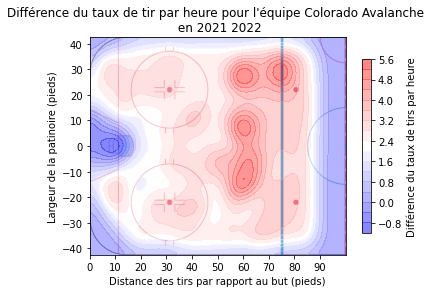

In [30]:
from scipy.ndimage import gaussian_filter
from matplotlib import image as mpimg

#variables à changer pour voir les résultats pour une équipe et une année données
selected_team = 'Colorado Avalanche'
selected_year = 2021
data=df.copy()

team_filtered_data = data[(data['team.name'] == selected_team) &
                        (data['about.dateTime'] == selected_year)]

accrossteam_filtered_data = data[data['about.dateTime'] == selected_year]

excess_df=excess_for_team(team_filtered_data, accrossteam_filtered_data)
excess_df=excess_df.reset_index()

x, y = np.meshgrid(np.linspace(0,100, 101),
                   np.linspace(-42.5,42.5,81))


positions = np.vstack([x.ravel(), y.ravel()])

z=griddata((excess_df['coordinates.x'], excess_df['coordinates.y']), excess_df['excess_shots'], (x,y), method='cubic', fill_value=0)
z=pd.DataFrame(z)*100
zsmooth=gaussian_filter(z, sigma=4)


rink_image = mpimg.imread('left_half.png') 
fig, ax = plt.subplots()
# Display the rink image in the background
ax.set_facecolor('white')
ax.imshow(rink_image, origin='lower', extent=[0, 100, -42.5, 42.5])
contour = ax.contourf(x, y, zsmooth, cmap='bwr', levels=(20), alpha=0.5, origin='lower', extent=[0, 100, -42.5, 42.5])
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', label='Différence du taux de tirs par heure', shrink=0.8, aspect=20)
plt.title(f"Différence du taux de tir par heure pour l'équipe {selected_team} \n en {selected_year} {selected_year+1}")
plt.xticks(np.arange(0, 100, 10))
plt.xlabel('Distance des tirs par rapport au but (pieds)')
plt.ylabel('Largeur de la patinoire (pieds)')
plt.show()


# Test widget

In [25]:
with open('left_half.png', "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
img = Image.open(io.BytesIO(base64.b64decode(encoded_image)))
ommg=img
ommg.save('nhl_rinkk.png')


In [26]:
img = Image.open('nhl_rinkk.png')
width, height = img.size
print(f'Image dimensions: {width}x{height}')

Image dimensions: 550x467


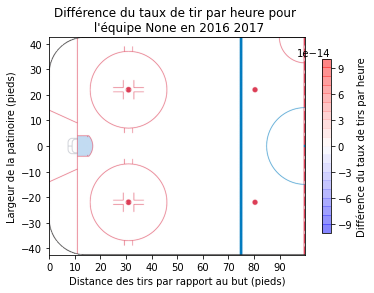

/Users/ceciliaacosta/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning:

The following kwargs were not used by contour: 'cmin', 'cmax'



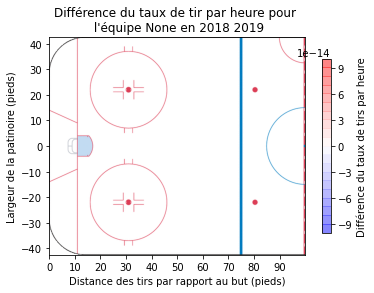

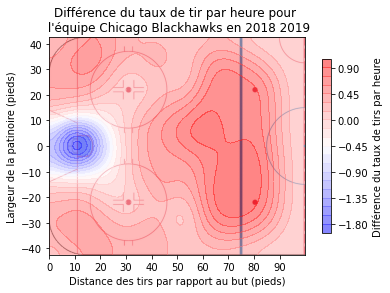

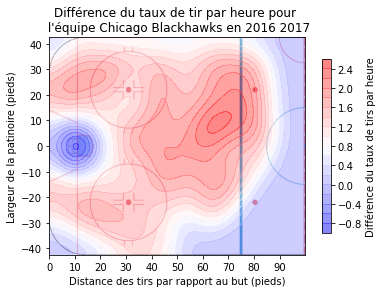

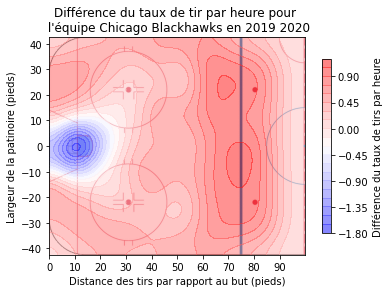

In [28]:
import matplotlib.pyplot as plt
import plotly.tools as tls
import mpld3

data=df.copy()
# Sample ice rink image (replace with your image)
ice_rink_image_path = 'nhl_rinkk.png'  # Replace with your ice rink image

# Load the ice rink image
with open(ice_rink_image_path, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")

app=dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Create the Dash HTML layout
# Create dropdown menus for team, season, and year
team_dropdown = dcc.Dropdown(
    id='team-dropdown',
    options=[{'label': team, 'value': team} for team in data['team.name'].unique()]
)

year_dropdown = dcc.Dropdown(
    id='year-dropdown',
    options=[{'label': year, 'value': year} for year in data['about.dateTime'].unique()],
    value=data['about.dateTime'].unique()[0]
)

# Create the initial layout with dropdowns and the image
html_matplotlib = ''

app.layout = dbc.Container([
    html.H1('Taux de tirs par heure pour une équipe, par rapport à la moyenne de la ligue'),
    team_dropdown,
    year_dropdown,
    html.Iframe(
        id='shot-map',
        srcDoc=html_matplotlib,
        style= {'width': '100%', 'height': '500px', 'border-width': '5'})])

# code inspiré par : https://community.plotly.com/t/converting-matplot-image-fig-to-plotly-object/66817

@app.callback(
    Output('shot-map', 'srcDoc'),
    [Input('team-dropdown', 'value'), Input('year-dropdown', 'value')])
def generate_plot(selected_team, selected_year):

    # Filter the data for the selected team and year
    team_filtered_data = data[(data['team.name'] == selected_team) &
                            (data['about.dateTime'] == selected_year)]

    accrossteam_filtered_data = data[data['about.dateTime'] == selected_year]

    excess_df=excess_for_team(team_filtered_data, accrossteam_filtered_data)
    excess_df=excess_df.reset_index()

    x, y = np.meshgrid(np.linspace(0,100, 101),
                    np.linspace(-42.5,42.5,81))

    z=griddata((excess_df['coordinates.x'], excess_df['coordinates.y']), excess_df['excess_shots'], (x,y), method='cubic', fill_value=0)
    z=pd.DataFrame(z)*100
    zsmooth=gaussian_filter(z, sigma=6)

    # Load the ice rink image as the background
    img = Image.open(io.BytesIO(base64.b64decode(encoded_image)))
    fig, ax = plt.subplots()

    # Display the rink image in the background
    ax.imshow(img, origin='lower', extent=[0, 100, -42.5, 42.5])
    contour = ax.contourf(x, y, zsmooth, cmap='bwr', levels=(20), alpha=0.7, origin='lower', cmin=-1, cmax=1)
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', label='Différence du taux de tirs par heure', shrink=0.8, aspect=20)
    plt.title(f"Différence du taux de tir par heure pour \n l'équipe {selected_team} en {selected_year} {selected_year+1}")
    plt.xticks(np.arange(0, 100, 10))
    plt.xlabel('Distance des tirs par rapport au but (pieds)')
    plt.ylabel('Largeur de la patinoire (pieds)')

    # Save the plot as a temporary image
    global html_matplotlib
    html_matplotlib=mpld3.fig_to_html(fig)
    return html_matplotlib
  

if __name__ == '__main__':
    app.run_server(debug=True, port=8001)

